In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import scipy.stats as ss
import matplotlib 
import pickle
import os
import re

In [2]:
# Cell to contain all defined functions
def rename_columns(dataframe):
    df = dataframe
    cols = [c.replace(" ", "_").lower() for c in df.columns]
    cols[3] = "modified_sequence"
    df.columns = cols

def map_sample_names(dataframe):
    df = dataframe
    samples = list(set(df.file_name))
    regs = [r"\d*\_DIA\_", r"\.raw", r"\-"]
    res = {}
    for sample in samples:
        new_name = sample
        for reg in regs:
            new_name = re.sub(reg, "", new_name)
        if new_name not in res:
            res[sample] = new_name.lower()
    df.file_name = df.file_name.map(res)

def df_reduce_samples(samples, dataframe):
    df = dataframe
    return df[df.file_name.isin(samples)]

def pep_in_all_samples(peptide, mz, sample_list, dataframe):
    df = dataframe
    df = df[(df.modified_sequence==peptide) & 
            (df.precursor_mz==mz) & 
            (df.total_area_ms1 != 0)]
    return set(df.file_name)==set(sample_list), df.index.tolist()

def get_most_intense_charge(peptide, dataframe):
    df = dataframe
    df = df[df.modified_sequence==peptide]
    intensity = (df.total_area_ms1.describe()["max"])
    z = df[df.total_area_ms1==intensity]["precursor_charge"].item()
    return df[df.precursor_charge==z].index.tolist()

def collapse_proteins(sample_list, dataframe):
    df = dataframe
    proteins = list(set(df.protein_name))
    top = {}
    for sample in sample_list:
        base = {}
        sub = df[df.file_name==sample]
        proteins = list(set(df.protein_name))
        for protein in proteins:
            sub2 = sub[sub.protein_name==protein]
            base[protein] = sub2.total_area_ms1.sum()
        top[sample] = base 
    return pd.DataFrame(top)

def reduce_axis_labels(ax, factor, vert):    
    if vert.lower() == "x":
        plt.setp(ax.xaxis.get_ticklabels(), visible=False)    
        for label in ax.xaxis.get_ticklabels()[factor-1::factor]:        
            label.set_visible(True)
    elif vert.lower() == "y":
        plt.setp(ax.yaxis.get_ticklabels(), visible=False)    
        for label in ax.yaxis.get_ticklabels()[factor-1::factor]:        
            label.set_visible(True)

def has_x_peptides(dataframe, x, sample_list):
    df = dataframe
    counts = df.protein_name.value_counts()/len(sample_list)
    return df[df.protein_name.isin(counts[counts>=x].index)]

def remove_outliers(array, max_devs):
    mean = np.mean(array)
    std_dev = np.std(array)
    dist = abs(array-mean)
    not_outlier = dist < max_devs * std_dev
    return np.where(dist < max_devs * std_dev)

def clean_arrays(xs, ys):
    val_x = remove_outliers(np.log2(xs), 2)[0]
    val_y = remove_outliers(np.log2(ys), 2)[0]
    ids = [i for i in val_x if i in val_y]
    return ids

def has_x_transitions(peptide, mz, x, samples, dataframe):
    df = dataframe
    df = df[(df.area>0) & (df.peptide_sequence==peptide) &
            (df.precursor_mz==mz) & (df.file_name.isin(samples))]
    df = df.sort_values(["file_name", "area"], ascending=False)
    counts = df.file_name.value_counts().values
    num_trans = sum(counts)
    trans = []
    if len(counts)==len(samples) and (num_trans//len(samples)) >= x:
        for s in samples:
            sub = df[df.file_name==s]
            trans.extend(sub.index[:3])
        return True, trans
    return False, trans

def sum_transitions(samples, dataframe):
    df = dataframe
    master = {}
    for sample in samples:
        slave = {}
        sub = df[df.file_name==sample]
        for r in zip(sub.protein_name, sub.area):
            prot, area = r[0], r[1]
            if not prot in slave:
                slave[prot] = area
            else:
                slave[prot] += area
        master[sample] = slave
    return pd.DataFrame(master)

In [7]:
file = r"E:\Research\Data Workup\CSF_Skyline_Quant_20200124\01272020_CSF_DIA_Top2top3_0.6_0.6.csv"
df = pd.read_csv(file)
rename_columns(df)
map_sample_names(df)
ms1 = df[df.fragment_ion=="precursor"]
precs = ["precursor", "precursor [M+1]", "precursor [M+2]"]
ms2 = df[~df.fragment_ion.isin(precs)]
ms2.head()

,file_name,protein_name,peptide_sequence,modified_sequence,precursor_mz,precursor_charge,fragment_ion,area,total_area_ms1,total_area_fragment
54,ctrl1_rep1,sp|A0A0A0MS15|HV349_HUMAN,SIAYLQMNSLK,SIAYLQMNSLK,634.33938,2,b2,32087140,53500528,257655808
55,ctrl1_rep2,sp|A0A0A0MS15|HV349_HUMAN,SIAYLQMNSLK,SIAYLQMNSLK,634.33938,2,b2,9057701,100641864,35892984
56,ctrl2_rep1,sp|A0A0A0MS15|HV349_HUMAN,SIAYLQMNSLK,SIAYLQMNSLK,634.33938,2,b2,11783490,3895099,99978976
57,ctrl2_rep2,sp|A0A0A0MS15|HV349_HUMAN,SIAYLQMNSLK,SIAYLQMNSLK,634.33938,2,b2,48551812,3212994,398603584
58,ctrl3_rep1,sp|A0A0A0MS15|HV349_HUMAN,SIAYLQMNSLK,SIAYLQMNSLK,634.33938,2,b2,27370350,4060443,214149616


In [112]:
# define function to check if there are at least X 
# transitions with > 0 area
samples = ["ctrl1_rep1", "ctrl1_rep2"]
ms2_reduced = df_reduce_samples(samples, ms2)

    
has_x_transitions("SIAYLQMNSLK", 634.33938, 3, samples, ms2_reduced)

(True, [126, 108, 54, 73, 55, 91])

In [37]:
# comparing technical_replicates ctrl1_1 and ctrl1_2
samples = ["ctrl1_rep1", "ctrl1_rep2"]
ctrl1_ms1 = df_reduce_samples(samples, ms1)
reduced_ctrl1 = ctrl1_ms1[["modified_sequence", "precursor_mz"]].drop_duplicates()

ms1_idxs = []
ms2_idxs = []
for r in zip(reduced_ctrl1.modified_sequence, reduced_ctrl1.precursor_mz):
    sequence, mz = r[0], r[1]
    in_all, indexes = pep_in_all_samples(sequence, mz, samples, ctrl1_ms1)
    if in_all and has_3_trans:
        ms1_idxs.extend(indexes)
ctrl1_valid_peps = ctrl1_ms1.loc[idxs, :]
ctrl1_with_3 = has_x_peptides(ctrl1_valid_peps, 3, samples)

charge_red_idx = []
for pep in list(set(ctrl1_with_3.modified_sequence)):
    z = get_most_intense_charge(pep, ctrl1_with_3)
    charge_red_idx.extend(z)
ctrl1_with_3 = ctrl1_with_3.loc[charge_red_idx, :]

# check to see if each peptide has 3 transitions
for r in zip(ctrl1_with_3.modified_sequence, ctrl1_with_3.precursor_mz):
    sequence, mz = r[0], r[1]


In [38]:
ctrl1_with_3

,file_name,protein_name,peptide_sequence,modified_sequence,precursor_mz,precursor_charge,fragment_ion,area,total_area_ms1,total_area_fragment
331236,ctrl1_rep1,sp|P10909|CLUS_HUMAN,EPQDTYHYLPFSLPHR,EPQDTYHYLPFSLPHR,500.746979,4,precursor,3354559488,9424068608,213380752
331237,ctrl1_rep2,sp|P10909|CLUS_HUMAN,EPQDTYHYLPFSLPHR,EPQDTYHYLPFSLPHR,500.746979,4,precursor,3278359040,9307132928,217038528
158472,ctrl1_rep1,sp|P02751|FINC_HUMAN,LGVRPSQGGEAPR,LGVRPSQGGEAPR,662.360024,2,precursor,158213376,304514080,5111611
158473,ctrl1_rep2,sp|P02751|FINC_HUMAN,LGVRPSQGGEAPR,LGVRPSQGGEAPR,662.360024,2,precursor,55194,17242122,152336
36792,ctrl1_rep1,sp|O94985|CSTN1_HUMAN,QFPTPGIR,QFPTPGIR,458.255977,2,precursor,170863632,247146816,31784952
36793,ctrl1_rep2,sp|O94985|CSTN1_HUMAN,QFPTPGIR,QFPTPGIR,458.255977,2,precursor,60390184,79876960,6265886
289602,ctrl1_rep1,sp|P08603|CFAH_HUMAN,TTCWDGKLEYPTCAK,TTC[+57.021464]WDGKLEYPTC[+57.021464]AK,610.611412,3,precursor,452650816,1229433216,17811546
289603,ctrl1_rep2,sp|P08603|CFAH_HUMAN,TTCWDGKLEYPTCAK,TTC[+57.021464]WDGKLEYPTC[+57.021464]AK,610.611412,3,precursor,434418688,1087026688,16907868
122616,ctrl1_rep1,sp|P01871|IGHM_HUMAN,FTCTVTHTDLPSPLK,FTC[+57.021464]TVTHTDLPSPLK,572.959028,3,precursor,146955744,400255360,3144465
122617,ctrl1_rep2,sp|P01871|IGHM_HUMAN,FTCTVTHTDLPSPLK,FTC[+57.021464]TVTHTDLPSPLK,572.959028,3,precursor,130651728,316053216,3092720


Completed loop in 0.028000354766845703 seconds

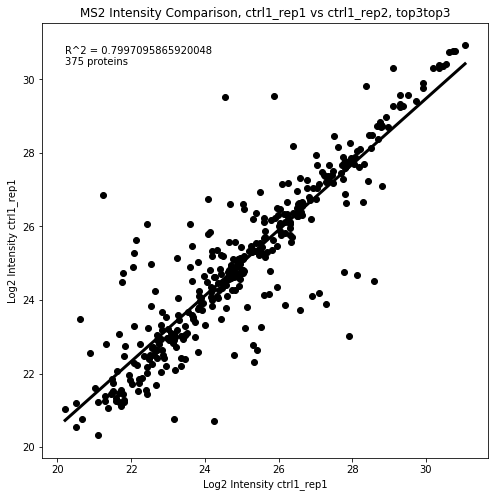

In [147]:
# find all proteins with 3 peptides and each peptide has 3 transitions
samples = ["ctrl1_rep1", "ctrl1_rep2"]
ctrl1_ms1 = df_reduce_samples(samples, ms1)
reduced_ms1 = ctrl1_ms1[["modified_sequence", "precursor_mz"]].drop_duplicates()
import time 
ms1_idxs = []
ms2_idxs = []
for r in zip(reduced_ms1.modified_sequence, reduced_ms1.precursor_mz):
    t1 = time.time()
    sequence, mz = r[0], r[1]
    in_all, indexes = pep_in_all_samples(sequence, mz, samples, ctrl1_ms1)
    has_3_trans, ms2_indexes = has_x_transitions(sequence, mz, 3, samples, ms2)
    if in_all and has_3_trans:
        ms1_idxs.extend(indexes)
        ms2_idxs.extend(ms2_indexes)
    t2 = time.time()
    print(f"Completed loop in {t2-t1} seconds", end="\r")
valid_peptides = ctrl1_ms1.loc[idxs, :]
valid_transitions = ms2.loc[ms2_idxs, :]

t = sum_transitions(samples, valid_transitions).dropna()

fig, ax = plt.subplots(figsize=(8, 8))
xs, ys = np.log2(t[samples[0]].values), np.log2(t[samples[1]].values)
ids = clean_arrays(xs, ys)
xs = xs[ids]
ys = ys[ids]
slope, intercept, r, p, std_err = ss.linregress(xs, ys)
plt.plot([min(xs), max(xs)], [min(xs)*slope+intercept, max(xs)*slope+intercept],
         linewidth=3, color="k")
plt.scatter(xs, ys, color="k") 
texstr = [f"R^2 = {r**2}", f"{len(xs)} proteins"]
ax.text(min(xs), max(ys), "\n".join(texstr), verticalalignment="top")
ax.set_title(f"MS2 Intensity Comparison, {samples[0]} vs {samples[1]}, top3top3")
ax.set_xlabel(f"Log2 Intensity {samples[0]}")
ax.set_ylabel(f"Log2 Intensity {samples[0]}")
None

Completed loop in 0.030002355575561523 seconds

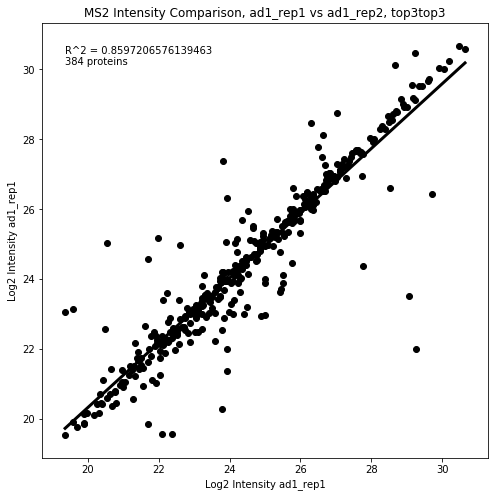

In [148]:

# find all proteins with 3 peptides and each peptide has 3 transitions
samples = ["ad1_rep1", "ad1_rep2"]
ctrl1_ms1 = df_reduce_samples(samples, ms1)
reduced_ms1 = ctrl1_ms1[["modified_sequence", "precursor_mz"]].drop_duplicates()
import time 
ms1_idxs = []
ms2_idxs = []
for r in zip(reduced_ms1.modified_sequence, reduced_ms1.precursor_mz):
    t1 = time.time()
    sequence, mz = r[0], r[1]
    in_all, indexes = pep_in_all_samples(sequence, mz, samples, ctrl1_ms1)
    has_3_trans, ms2_indexes = has_x_transitions(sequence, mz, 3, samples, ms2)
    if in_all and has_3_trans:
        ms1_idxs.extend(indexes)
        ms2_idxs.extend(ms2_indexes)
    t2 = time.time()
    print(f"Completed loop in {t2-t1} seconds", end="\r")
valid_peptides = ctrl1_ms1.loc[ms1_idxs, :]
valid_transitions = ms2.loc[ms2_idxs, :]

t = sum_transitions(samples, valid_transitions).dropna()

fig, ax = plt.subplots(figsize=(8, 8))
xs, ys = np.log2(t[samples[0]].values), np.log2(t[samples[1]].values)
ids = clean_arrays(xs, ys)
xs = xs[ids]
ys = ys[ids]
slope, intercept, r, p, std_err = ss.linregress(xs, ys)
plt.plot([min(xs), max(xs)], [min(xs)*slope+intercept, max(xs)*slope+intercept],
         linewidth=3, color="k")
plt.scatter(xs, ys, color="k") 
texstr = [f"R^2 = {r**2}", f"{len(xs)} proteins"]
ax.text(min(xs), max(ys), "\n".join(texstr), verticalalignment="top")
ax.set_title(f"MS2 Intensity Comparison, {samples[0]} vs {samples[1]}, top3top3")
ax.set_xlabel(f"Log2 Intensity {samples[0]}")
ax.set_ylabel(f"Log2 Intensity {samples[0]}")
None

Completed loop in 0.0280303955078125 seconds

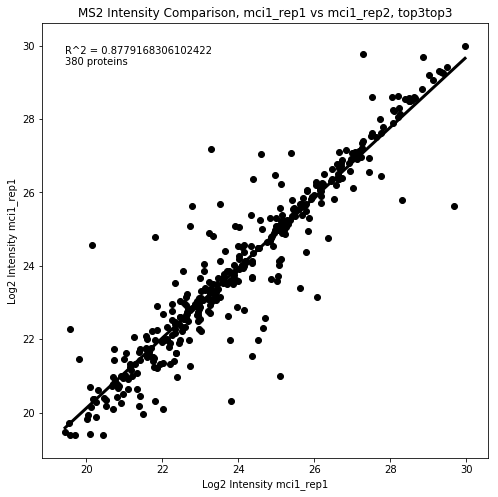

In [149]:
# find all proteins with 3 peptides and each peptide has 3 transitions
samples = ["mci1_rep1", "mci1_rep2"]
ctrl1_ms1 = df_reduce_samples(samples, ms1)
reduced_ms1 = ctrl1_ms1[["modified_sequence", "precursor_mz"]].drop_duplicates()
import time 
ms1_idxs = []
ms2_idxs = []
for r in zip(reduced_ms1.modified_sequence, reduced_ms1.precursor_mz):
    t1 = time.time()
    sequence, mz = r[0], r[1]
    in_all, indexes = pep_in_all_samples(sequence, mz, samples, ctrl1_ms1)
    has_3_trans, ms2_indexes = has_x_transitions(sequence, mz, 3, samples, ms2)
    if in_all and has_3_trans:
        ms1_idxs.extend(indexes)
        ms2_idxs.extend(ms2_indexes)
    t2 = time.time()
    print(f"Completed loop in {t2-t1} seconds", end="\r")
valid_peptides = ctrl1_ms1.loc[ms1_idxs, :]
valid_transitions = ms2.loc[ms2_idxs, :]

t = sum_transitions(samples, valid_transitions).dropna()

fig, ax = plt.subplots(figsize=(8, 8))
xs, ys = np.log2(t[samples[0]].values), np.log2(t[samples[1]].values)
ids = clean_arrays(xs, ys)
xs = xs[ids]
ys = ys[ids]
slope, intercept, r, p, std_err = ss.linregress(xs, ys)
plt.plot([min(xs), max(xs)], [min(xs)*slope+intercept, max(xs)*slope+intercept],
         linewidth=3, color="k")
plt.scatter(xs, ys, color="k") 
texstr = [f"R^2 = {r**2}", f"{len(xs)} proteins"]
ax.text(min(xs), max(ys), "\n".join(texstr), verticalalignment="top")
ax.set_title(f"MS2 Intensity Comparison, {samples[0]} vs {samples[1]}, top3top3")
ax.set_xlabel(f"Log2 Intensity {samples[0]}")
ax.set_ylabel(f"Log2 Intensity {samples[0]}")
None

In [146]:
set(valid_peptides.modified_sequence)==set(valid_peptides.modified_sequence)

True

In [150]:
p

1.0446403461623946e-174